In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


In [2]:
from collections import defaultdict
from io import StringIO
from pathlib import Path
from typing import Tuple

import lovely_numpy as ln
import monai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import pytorch_lightning as pl
import seaborn as sns
import torch
from monai.data import CSVDataset
from monai.data import DataLoader
from monai.inferers import sliding_window_inference
from monai.visualize import matshow3d
from torchmetrics import Dice
from torchmetrics import MetricCollection
from tqdm.auto import tqdm

2023-04-18 17:26:24,224 - Created a temporary directory at /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmps9__zn26
2023-04-18 17:26:24,224 - Writing /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmps9__zn26/_remote_module_non_scriptable.py


In [3]:
KAGGLE_DIR = PATH / "kaggle"

INPUT_DIR = KAGGLE_DIR / "input"

COMPETITION_DATA_DIR = INPUT_DIR / "vesuvius-challenge-ink-detection"

TRAIN_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_train_0.7.csv"
TEST_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_test_1.0.csv"



In [4]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# scroll_1 size = 8181, 6330
# scroll_2 size = 14830, 9506
# scroll_3 size = 7606, 5249



class MONAI_CSV_Scrolls_Dataset(pl.LightningDataModule):

    def __init__(self,
                 patch_size = 512,
                 z_start = 0,
                 z_dim = 64,
                 shared_height = None,
                 downsampling =None,
                 train__fragment_id = [1],
                 val_fragment_id = [3],
                 stage = 'train',
                 batch_size=1,
                 num_samples = 1,
                 num_workers =0 ,
                 on_gpu= False,
                 data_csv_path =None,


                 ):
        super().__init__()
        self.save_hyperparameters()
    
        self.df = pd.read_csv(data_csv_path)
        self.keys = ("volume_npy", "mask_npy", "label_npy")
        self.train_transform = self.train_transforms()
        self.val_transform = self.val_transforms()
        self.predict_transform = self.predict_transforms()
        
        
        
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_val_df = self.df[self.df.stage == "train"].reset_index(drop=True)

            train_df = train_val_df[
                train_val_df.fragment_id != self.hparams.val_fragment_id
            ].reset_index(drop=True)

            val_df = train_val_df[
                train_val_df.fragment_id == self.hparams.val_fragment_id
            ].reset_index(drop=True)

            self.train_dataset = self._dataset(train_df, self.train_transform)
            self.val_dataset = self._dataset(val_df, self.val_transform)

            print(f"# train: {len(self.train_dataset)}")
            print(f"# val: {len(self.val_dataset)}")

        if stage == "predict" or stage is None:
            predict_df = self.df[self.df.stage == "test"].reset_index(drop=True)
            self.predict_dataset = self._dataset(predict_df, self.predict_transform)

            
    def _dataset(self, df, transform):
        return CSVDataset(
            src=df,
            transform=transform,
        )
    
    
    
    def train_transforms_old(self):
        return monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(
                    keys="volume_npy",
                ),
                monai.transforms.LoadImaged(
                    keys=("mask_npy", "label_npy"),
                    ensure_channel_first=True,
                ),
               
            ]
        )
        
    def train_transforms(self):
        return monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(
                    keys="volume_npy",
                ),
                monai.transforms.LoadImaged(
                    keys=("mask_npy", "label_npy"),
                    ensure_channel_first=True,
                ),
                
                monai.transforms.RandWeightedCropd(
                    keys=("volume_npy", "mask_npy", "label_npy"),
                    spatial_size=self.hparams.patch_size,
                    num_samples=self.hparams.num_samples,
                    w_key="mask_npy",
                ),
                monai.transforms.RandFlipd(
                    keys=self.keys,
                    prob=0.5,
                    spatial_axis=0,
                ),
                monai.transforms.RandFlipd(
                    keys=self.keys,
                    prob=0.5,
                    spatial_axis=1,
                ),
            ]
        )
        

    def val_transforms(self):
        return monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(
                    keys="volume_npy",
                ),
                monai.transforms.LoadImaged(
                    keys=("mask_npy", "label_npy"),
                    ensure_channel_first=True,
                ),
            ]
        )
    
    
    def predict_transforms(self):
        return monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(
                    keys="volume_npy",
                ),
                monai.transforms.LoadImaged(
                    keys="mask_npy",
                    ensure_channel_first=True,
                ),
            ]
        )
    

        

    def train_dataloader(self):
        return self._dataloader(self.train_dataset, train=True)

    def val_dataloader(self):
        return self._dataloader(self.val_dataset)

    def predict_dataloader(self):
        return self._dataloader(self.predict_dataset)
    

    def _dataloader(self, dataset, train=False):
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=train,
            num_workers=self.hparams.num_workers,
        )



In [5]:
def visualize_dataloaders(dataloaders, train=True):
    for stage, dataloader in dataloaders.items():
        for batch_idx, batch in enumerate(dataloader):
            volumes = batch["volume_npy"]
            masks = batch["mask_npy"]
            
            if train:
                labels = batch["label_npy"]
            else: 
                labels = masks
                
            for volume, mask, label in zip(volumes, masks, labels):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                plt.suptitle(f"stage: {stage}, fragment: {batch_idx}")

                for idx, image in enumerate((volume, mask, label)):
                    matshow3d(
                        volume=image,
                        fig=axes[idx],
                        title=f"{list(image.shape)}, {image.min().item()}, {image.max().item()}",
                        vmin=0.0,
                        vmax=1.0,
                        every_n=2,
                        fill_value=1.0,
                        margin=4,
                        cmap="gray",
                    )

# train: 2
# val: 1


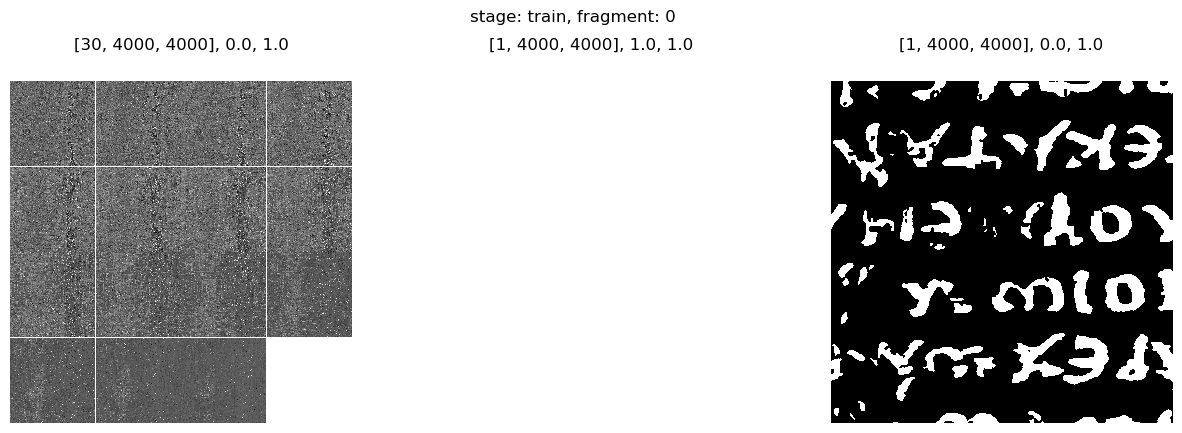

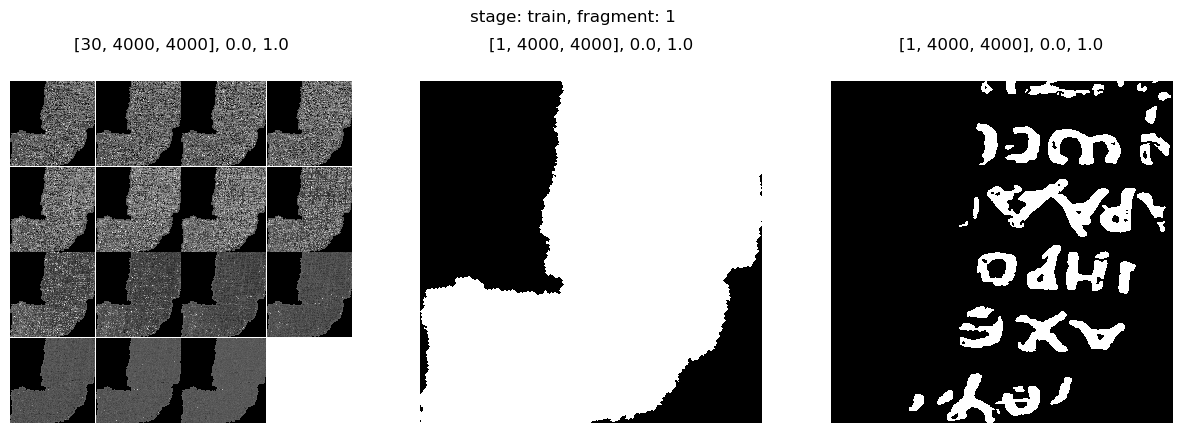

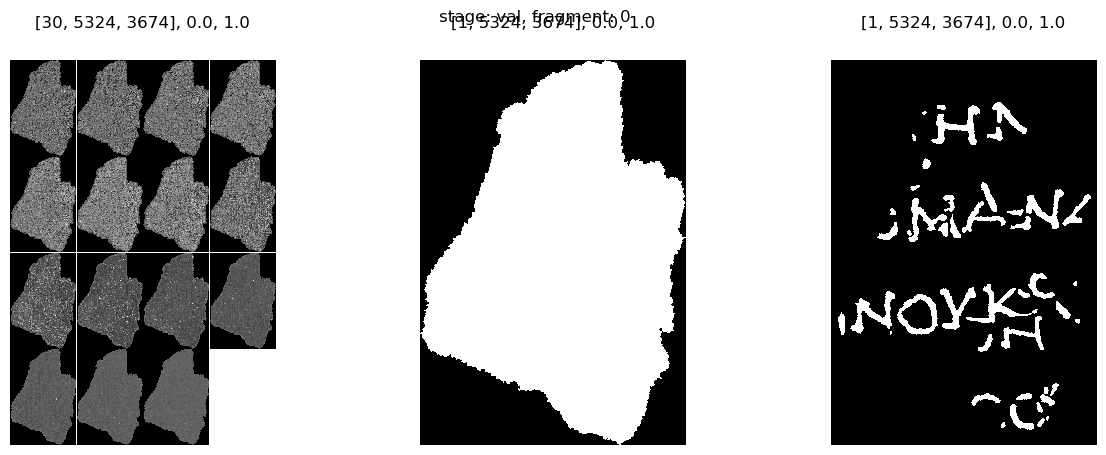

In [46]:
data_module = MONAI_CSV_Scrolls_Dataset(
    batch_size=1,
    data_csv_path=TRAIN_DATA_CSV_PATH,
    num_workers=0,
    num_samples=1,
    patch_size=(4000,4000),
    val_fragment_id=3,
)

data_module.setup(stage="fit")

dataloaders = {
    "train": data_module.train_dataloader(),
    "val": data_module.val_dataloader(),
}

visualize_dataloaders(dataloaders)

In [13]:
dataloader = data_module.train_dataloader()
for batch_idx, batch in enumerate(dataloader):
    if batch_idx==1:
        break
    volumes = batch["volume_npy"]
    masks = batch["mask_npy"]
    labales = batch['label_npy']
    print(volumes.shape)
    print(masks.shape)
    print(labales.shape)

torch.Size([1, 30, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


In [14]:
from lit_models.UNET_monai_lit import UNET_lit


In [20]:
model = monai.networks.nets.UNet(
                spatial_dims=2,
                in_channels=30, #z_dim
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                dropout=.2,
            )

In [21]:
model(volumes.as_tensor())

tensor([[[[ 0.7961,  0.1521,  0.7000,  ...,  0.0932,  0.2638,  0.2715],
          [ 0.4493, -0.2963,  0.7291,  ...,  0.3186,  0.1736,  0.2812],
          [ 0.7568,  0.5907,  0.5202,  ...,  0.8154,  0.0559,  0.3565],
          ...,
          [ 0.2508, -0.0518, -0.6589,  ...,  0.3343,  0.0760,  0.2951],
          [ 0.0039,  0.5330,  0.5608,  ...,  0.1778,  0.5325, -0.0837],
          [ 0.9163, -0.1166,  0.3104,  ...,  0.2471,  0.1060,  0.1471]]]],
       grad_fn=<AddBackward0>)

In [40]:
lit_model = UNET_lit( 
        z_dim = 30,
        patch_size = (512,512),
        sw_batch_size=16 ,
        eta_min = 1e-6,
        max_epochs = 700,
        weight_decay = 0.00005,
        learning_rate = 0.0003,
        gamma = 0.85,)

In [38]:
model(volumes.as_tensor())

tensor([[[[-0.0650,  0.3993,  0.0598,  ...,  1.3228,  0.4078,  0.1129],
          [-0.2885, -0.6444, -0.4788,  ..., -0.3298, -0.2696, -0.0608],
          [ 1.3850,  1.1653,  0.2653,  ...,  0.9403,  1.1575,  0.8189],
          ...,
          [ 0.3026,  2.1480, -1.6097,  ...,  1.8369,  1.1741,  0.1205],
          [ 0.2573,  1.3150,  0.8729,  ...,  0.3429, -0.0648,  0.4581],
          [ 0.3843, -0.5893, -1.5212,  ..., -0.2018,  0.7786,  0.1259]]]],
       grad_fn=<AddBackward0>)

In [41]:
trainer = pl.Trainer(
        accelerator='gpu',
        #benchmark=True,
        max_epochs=700,
        check_val_every_n_epoch= 1,
        devices=1,
        #fast_dev_run=fast_dev_run,
        logger=pl.loggers.CSVLogger(save_dir='logs/'),
        log_every_n_steps=1,
        
        overfit_batches=0,
        #precision=16,
         accumulate_grad_batches=1,)

trainer.fit(lit_model, datamodule=dataset)

2023-04-18 19:06:25,306 - GPU available: True (mps), used: True
2023-04-18 19:06:25,307 - TPU available: False, using: 0 TPU cores
2023-04-18 19:06:25,308 - IPU available: False, using: 0 IPUs
2023-04-18 19:06:25,308 - HPU available: False, using: 0 HPUs


AttributeError: 'CSVDataset' object has no attribute 'prepare_data_per_node'

{'Unnamed: 0': tensor([0]),
 'mask_png': ['/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/kaggle/input/vesuvius-challenge-ink-detection/train/1/mask.png'],
 'stage': ['train'],
 'fragment_id': tensor([1]),
 'mask_npy': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]),
 'label_png': ['/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/kaggle/input/vesuvius-challenge-ink-detection/train/1/inklabels.png'],
 'label_npy': tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'volumes_dir': ['/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/kaggle/input/vesuviu